In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import stumpy
from sklearn.preprocessing import StandardScaler
from dao import DataLoading
from matplotlib.patches import Rectangle
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

In [10]:
def visualize_data(datafilename,data):
    fig,ax = plt.subplots(1,1,figsize = (15,15))
    test_data_start_pt = int(re.findall(r'[0-9]*.txt',datafilename)[0].split('.')[0])
    datasize = len(data)
    ax.plot(list(range(0,test_data_start_pt)),data[:test_data_start_pt],'b')
    ax.plot(list(range(test_data_start_pt,datasize)),data[test_data_start_pt:datasize],'r')


In [11]:
def return_normal_anoalous_data(datafilename,data):
    test_data_start_pt = int(re.findall(r'[0-9]*.txt',datafilename)[0].split('.')[0])
    return data[:test_data_start_pt], data[test_data_start_pt:len(data)]

In [ ]:
from dao import matrixprofile_bruteforce
import matplotlib.pyplot as plt
time_series = [0, 1, 3, 2, 9, 1, 14, 15, 1, 2, 2, 10, 7]
n = len(time_series)
m = 4

results_dict = matrixprofile_bruteforce.calculate_matrix_profile(time_series,m)
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(range(len(time_series)),time_series, color = 'b')
ax[1].plot([i for i in results_dict],[results_dict[i] for i in results_dict], color = 'r')

In [12]:
len(os.listdir(DataLoading.file_path))

251

<h1>Matrix Profile</h1>

In [13]:
#using A-B join
results_dict = dict()
m = 50
for i in range(1,51):
    print(i)
    #lengthtuple = len_list[i - 1]
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = i)
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    #to select the window to be used we need to find the minimum length of the test and train sets
    #min_len = min(lengthtuple)
    #m = [np.floor(min_len/200),np.floor(min_len/100),np.floor(min_len/50),np.floor(min_len/20)
    mp = stumpy.stump(test_scaled.reshape(test_scaled.shape[0],),m,train_scaled.reshape(train_scaled.shape[0],),ignore_trivial=False,normalize=True)
    position_of_firstanomaly = np.argsort(mp[:,0])[-1]
    position_of_secondanomaly = np.argsort(mp[:,0])[-2]
    score_of_firstanomaly = sorted(mp[:,0],reverse=True)[0]
    score_of_secondanomaly = sorted(mp[:,0],reverse=True)[1]
    #first anomaly,second anomaly
    results_dict[i] = [position_of_firstanomaly + test_data_start_pt,position_of_secondanomaly + test_data_start_pt,score_of_firstanomaly,score_of_secondanomaly]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [15]:
idx = list(results_dict.keys())
outlier = [results_dict[i] for i in results_dict]
matrix_profile_50 = pd.DataFrame(data= np.array(outlier))
matrix_profile_50.to_csv('Matrix_Profile_50.csv')

In [14]:
idx = list(results_dict.keys())
first_outlier = [results_dict[i][0] for i in results_dict]
second_outlier = [results_dict[i][1] for i in results_dict]
first_outlier_peak = [results_dict[i][2] for i in results_dict]
second_outlier_peak = [results_dict[i][3] for i in results_dict]
data = dict()
data["First"] = first_outlier
data["First Peak"] = first_outlier_peak
data["Second"] = second_outlier
data["Second Peak"] = second_outlier_peak
matrix_profile_50 = pd.DataFrame(data= data)
matrix_profile_50.to_csv('Matrix_Profile_50_50.csv')

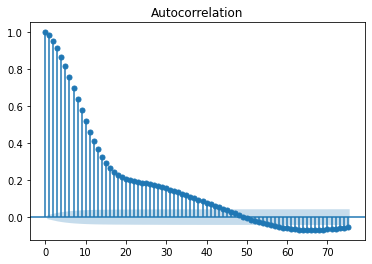

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)
plot_acf(train_scaled,lags = 75)
plt.show()

In [17]:
num_datasets = len(os.listdir(DataLoading.file_path))
results_dict_autoreg = dict()
for idx in range(1,51):
    train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = idx)
    train = np.array(train).reshape(-1,1)
    test = np.array(test).reshape(-1,1)
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)

    window = 50
    model = AutoReg(train_scaled,lags = window)
    model_fit = model.fit()
    coef = model_fit.params
    history = train_scaled[len(train_scaled) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    mean_sq_err = list()
    for t in range(len(test_scaled)):
        length = len(history)
        lag = [history[i] for i in range(length - window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window - d - 1]
        new_history = test_scaled[t]
        predictions.append(yhat)
        history.append(new_history)
        mean_sq_err.append((t + test_data_start_pt,mean_squared_error(new_history,yhat)))
    scores = sorted(mean_sq_err, key = lambda x:x[1],reverse=True)
    results_dict_autoreg[idx] = [scores[0][0],scores[0][1],scores[1][0],scores[1][1]]

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names wil

In [23]:
first_outlier_mp = [results_dict[i][0] for i in results_dict]
second_outlier_mp = [results_dict[i][1] for i in results_dict]
prominence_mp = [results_dict[i][2]/results_dict[i][3] for i in results_dict]
first_outlier_autoreg = [results_dict_autoreg[i][0] for i in results_dict_autoreg]
second_outlier_autoreg = [results_dict_autoreg[i][2] for i in results_dict_autoreg]
prominence_autoreg = [results_dict_autoreg[i][1]/results_dict_autoreg[i][3] for i in results_dict_autoreg]
data = {"First Outlier_MP":first_outlier_mp,"Second Outlier_MP":second_outlier_mp,"Prominence_MP":prominence_mp,"First Outlier Autoreg":first_outlier_autoreg,"Second Outlier Autoreg":second_outlier_autoreg,"Prominence Autoreg":prominence_autoreg}

df_results = pd.DataFrame(data)
df_results

,First Outlier_MP,Second Outlier_MP,Prominence_MP,First Outlier Autoreg,Second Outlier Autoreg,Prominence Autoreg
0,68662,68658,1.034998,61488,61713,1.052137
1,71111,51159,1.006334,61919,61459,1.057537
2,46657,46646,1.020105,61918,46706,1.066071
3,5526,5476,1.013691,5191,10781,1.118591
4,7171,7170,1.001264,5390,5389,2.328435
5,5681,5682,1.000806,5951,5463,1.125154
6,6503,6504,1.009302,6518,6519,2.129681
7,5322,5323,1.004518,5560,5548,1.260785
8,4871,4870,1.003570,4850,4851,3.370426
9,6014,6013,1.000810,6053,6054,5.101783


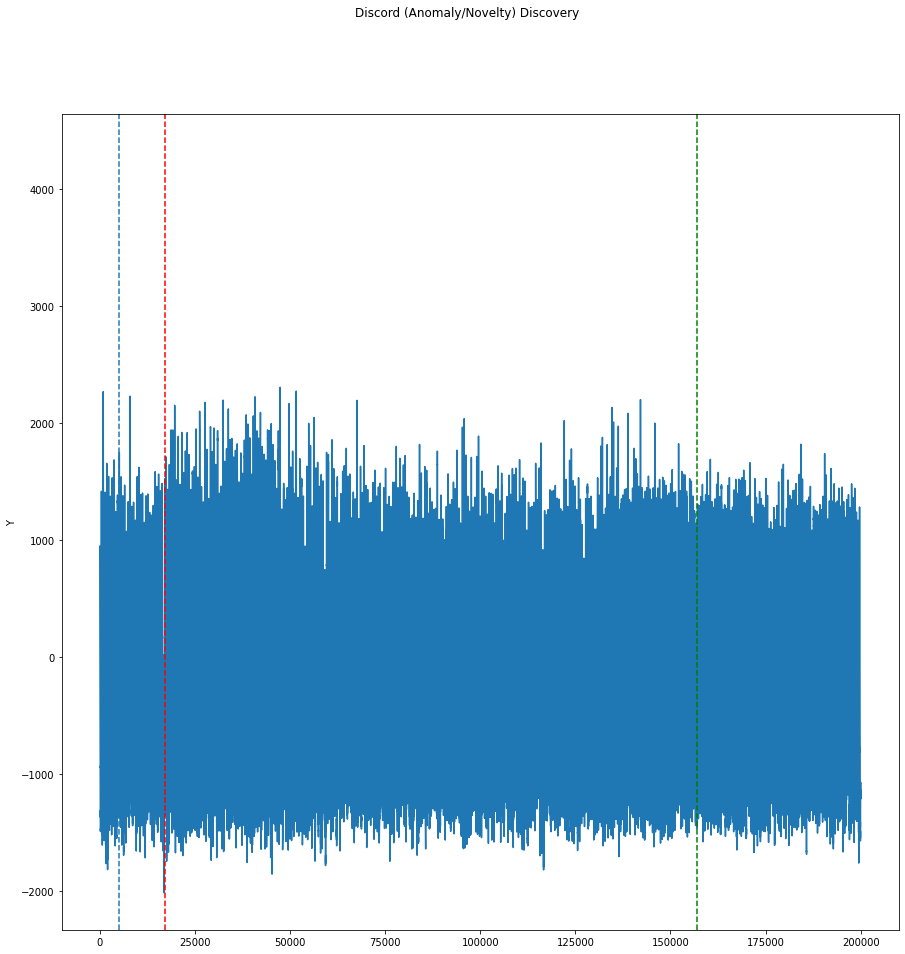

In [33]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 15)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((156896, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((17099, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
axs.axvline(x = (156896 + 25),linestyle = "dashed",color = 'g')
axs.axvline(x = (17099 + 25),linestyle = "dashed",color = 'r')

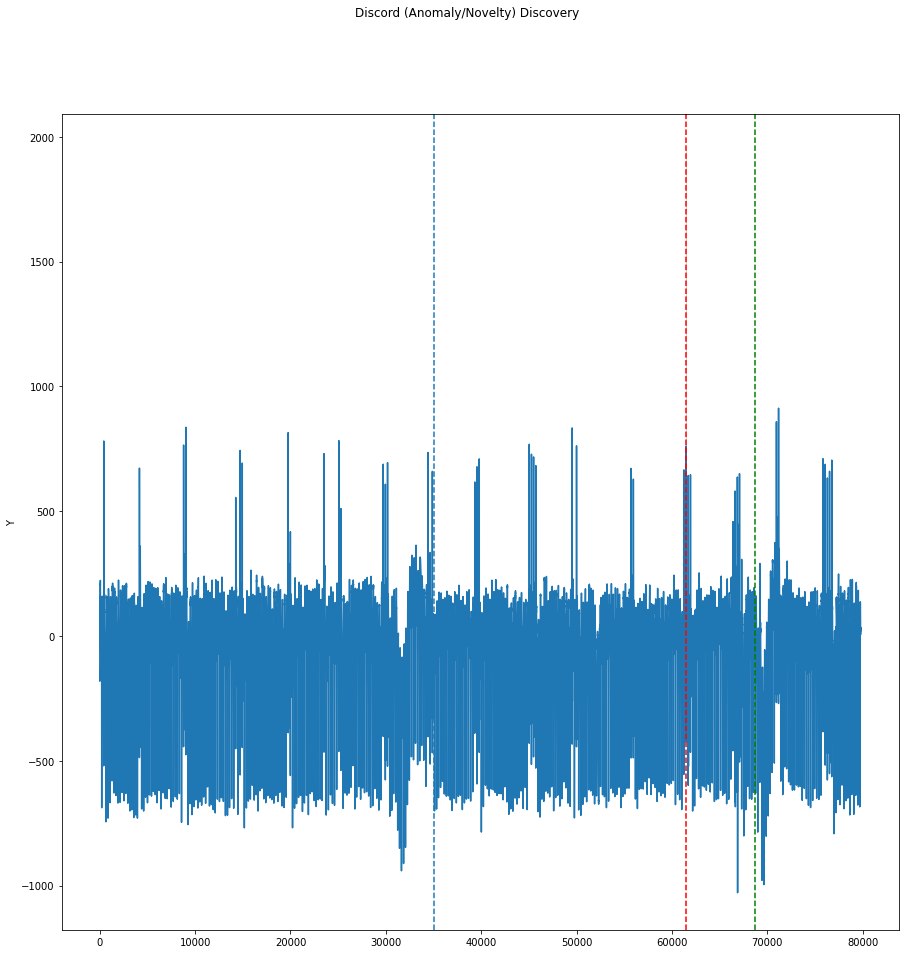

In [38]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 1)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((68662, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((61488, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
axs.axvline(x = (68662),linestyle = "dashed",color = 'g')
axs.axvline(x = (61488),linestyle = "dashed",color = 'r')

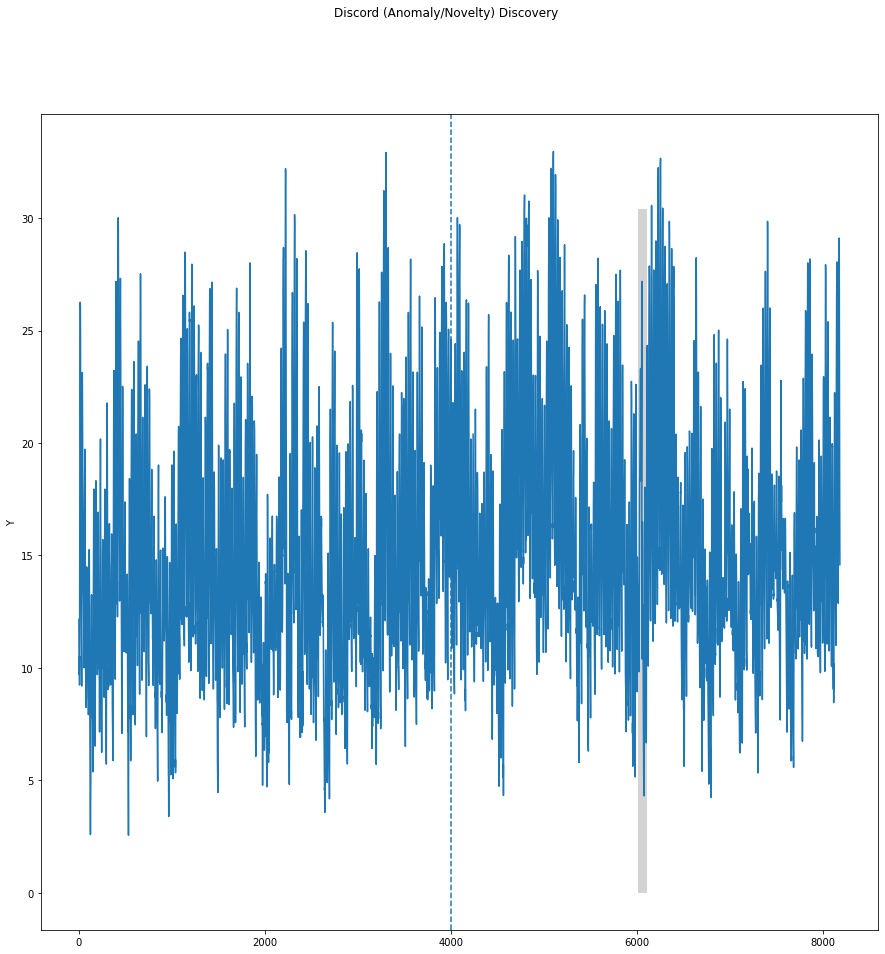

In [40]:
fig, axs = plt.subplots(1, figsize = (15,15), sharex=True, gridspec_kw={'hspace': 0})
train,test,test_data_start_pt = DataLoading.split_data(file_path = DataLoading.file_path,index = 10)
plt.suptitle('Discord (Anomaly/Novelty) Discovery')
axs.plot(np.concatenate((train,test)))
axs.set_ylabel('Y')
rect = Rectangle((6014, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect)
rect1 = Rectangle((6054, 0), 50, max(np.concatenate((train,test))) - min(np.concatenate((train,test))), facecolor='lightgrey')
axs.add_patch(rect1)
axs.axvline(x = np.array(train).shape[0], linestyle = "dashed")
#axs.axvline(x = (6014 + 25),linestyle = "dashed",color = 'g')
#axs.axvline(x = (6054 + 25),linestyle = "dashed",color = 'r')